In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import os
import glob
import importlib
import multiprocessing as mp
import itertools
import math
import random 

from matplotlib import pyplot as plt
import scipy.sparse as sparse
import scipy.io as sio
import scipy.stats as stats
import scipy.spatial.distance as dist
import numpy as np
import h5py
from tqdm import tqdm
import pandas as pd
import tables
import deepdish as dd

sys.path.append('/Users/johnmarshall/Documents/MATLAB/CNMF_E_jjm/python_wrapper/')
sys.path.append('/Users/johnmarshall/caiman_data/post_cnmfe_analysis')
import miniscope_analysis as ma 
import python_utils_jjm as utils_jjm
import jjm_post_cnmfe_fns as jjm
import align_msCam_tobehavior as align_tracking

from importlib import reload
%matplotlib inline

In [3]:
## function to plot traces for cnmfe output
def plot_traces(neuron_idxs, frame_range, data_to_plot, normalize=True, fsize=(15,10)):
    """Inputs:
    neuron_idxs : list of neuron indicies to plot, e.g. range(1, 2) or [3, 50, 90]
    frame_range : tuple (start_frame, end_frame)
    data_to_plot : list of data to plot (e.g. ['C', 'C_raw'])        
    """
    plt.figure(figsize=fsize)
    plt.axis('on')
    arrays_to_plot = [np.array(results.cnmfe_results[data]) for data in data_to_plot]
    for idx in neurons_idx:
        for array in arrays_to_plot:
            if normalize==True:
                plt.plot(utils_jjm.normalize(array[idx, frame_range[0]:frame_range[1]]) + idx)
            else:
                plt.plot(array[idx, frames[0]:frames[1]] + idx)
    return()

In [66]:
reload(utils_jjm)
reload(align_tracking)

<module 'align_msCam_tobehavior' from '/Users/johnmarshall/caimandata/post_cmfe_analysis/align_msCam_tobehavior.py'>

In [67]:
reload(ma)

<module 'miniscope_analysis' from '/Users/johnmarshall/caimandata/post_cmfe_analysis/miniscope_analysis.py'>

In [6]:
#GRIN013 
#results_file = '/Users/johnmarshall/Documents/MATLAB/29-Apr_16_52_17_wsortdecisionsout.mat'
#GRIN011 #cnmfe_analysis_files/GRIN_011
#results_file = '/Users/johnmarshall/Documents/MATLAB/04-May_00_39_45_wsortdecisions_out.mat'

results_file = '/Volumes/My_Passport/cnmfe_analysis_files/GRIN011/H10_M19_S59_01242019/04-May_00_39_45_wsortdecisions_out.mat'
results = ma.miniscope_session(results_file)

In [7]:
#add information about recording session 
results.session_info['mouse'] = 'GRIN011'
results.session_info['recording_date'] = '01_24_2019'

In [8]:
results.session_info

{'mouse': 'GRIN011', 'recording_date': '01_24_2019'}

()

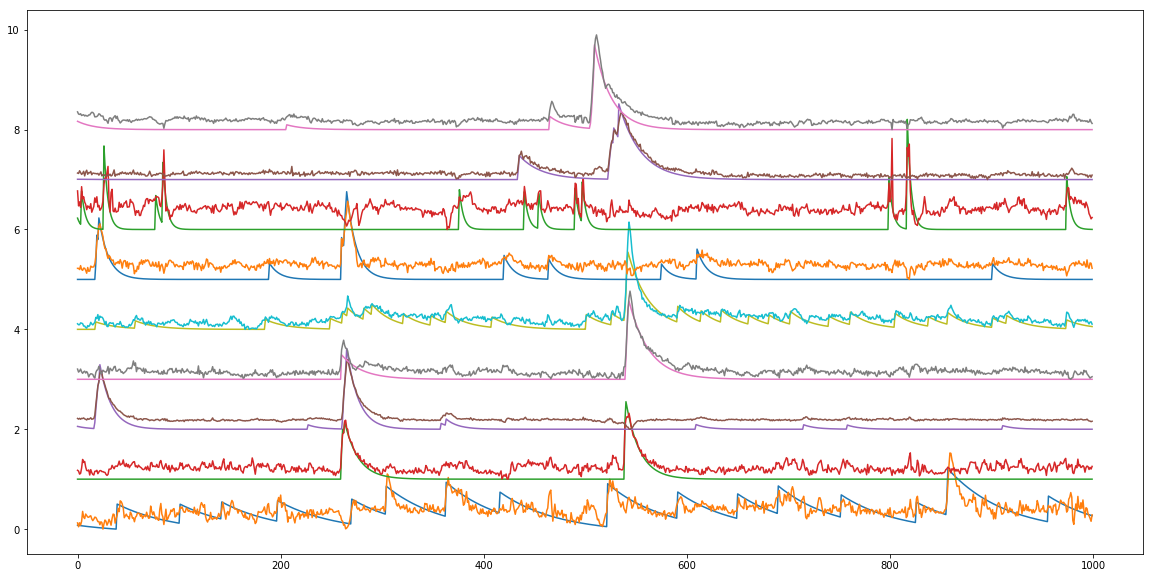

In [9]:
#plot traces from CNMFE object 
neurons_idx = range(0, 9)
plot_traces(range(1, 2), (9000, 10000), ['C', 'C_raw'], normalize=True, fsize=(20,10))

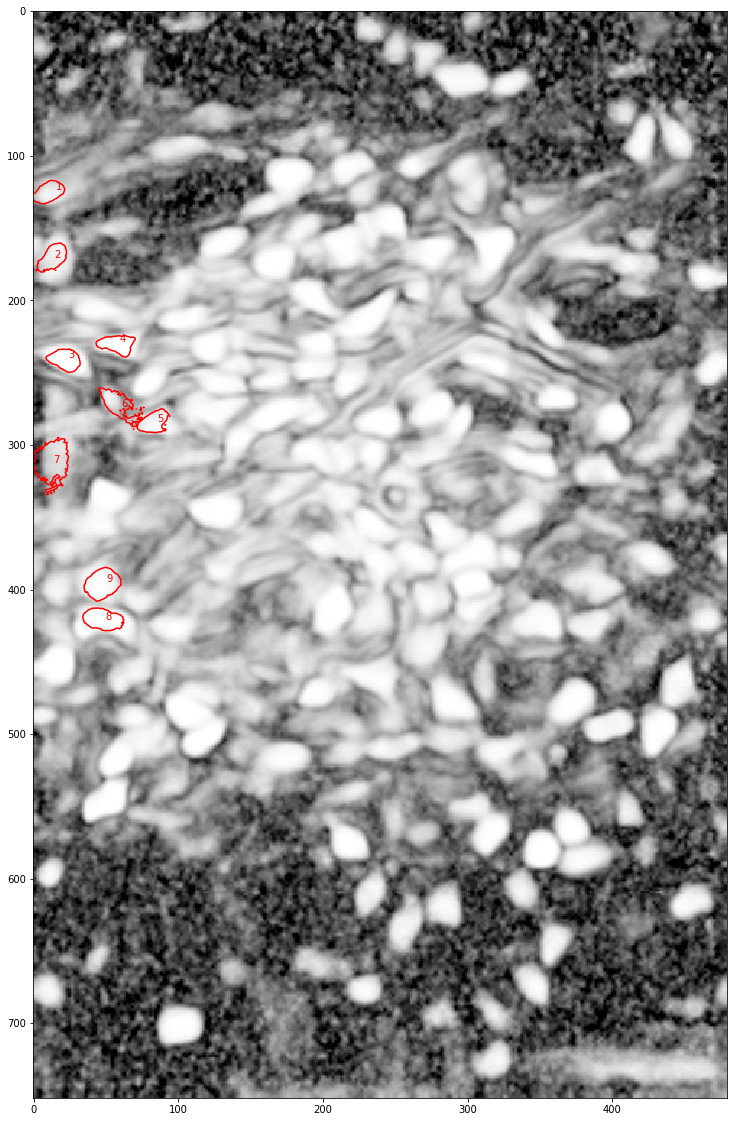

In [10]:
##coordinates of detected neurons
#should be able to input a list of coordinates to plot here 
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
coordinates = utils_jjm.plot_contours(results.cnmfe_results['A'].todense(), results.cnmfe_results['Cn'], list_to_plot=neurons_idx, display_numbers=True, maxthr=.6,cmap='gray', colors='r')

In [11]:
path_to_eztrackfiles = '/Volumes/My_Passport/cnmfe_analysis_files/GRIN011/H10_M19_S59_01242019/behavior_tracking_data/'
miniscope_time_stamp_file = path_to_eztrackfiles+'timestamp.dat'
location_files = glob.glob(path_to_eztrackfiles+'*_LocationOutput.csv')


In [68]:
frame_range = (1,10)
results.align_to_eztrackoutput(miniscope_time_stamp_file, location_files, frame_range)

          camNum  sysClock  buffer
frameNum                          
1              0         0       1
2              0         7       1
3              0        58       1
4              0       108       1
5              0       158       1
0
1
0
2
7
3
58
4
108
5
158
6
208
7
258
8
308
9
358
10
408


()

In [13]:
##load movement data and align to cnmfe output

path_to_eztrackfiles = '/Volumes/My_Passport/cnmfe_analysis_files/GRIN011/H10_M19_S59_01242019/behavior_tracking_data/'
miniscope_time_stamp_file = path_to_eztrackfiles+'timestamp.dat'
location_files = glob.glob(path_to_eztrackfiles+'*_LocationOutput.csv')

dfs = []
for file in location_files:
     dfs.append(pd.read_csv(file, usecols=[1,9,10,11]))

tracking_concacted = pd.concat(dfs)

In [22]:
tracking_concacted.head()

,File,X,Y,Distance
0,behavCam01.avi,148.643167,234.428597,0.000000
1,behavCam01.avi,146.245041,252.198583,17.931074
2,behavCam01.avi,144.924786,254.931079,3.034734
3,behavCam01.avi,143.056932,259.004403,4.481165
4,behavCam01.avi,138.982930,264.500309,6.841234


In [15]:
timestamps_df = pd.read_table(miniscope_time_stamp_file)

/Users/johnmarshall/miniconda2/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [16]:
CNMFE_frame_range=(1, 10)

In [17]:
timestamps_df.head()

,camNum,frameNum,sysClock,buffer
0,0,1,506567780,1
1,1,1,506567806,1
2,1,2,15,1
3,0,2,7,1
4,1,3,47,1


In [18]:
msCam_timestamps = timestamps_df[timestamps_df['camNum'] == 0].set_index('frameNum')[CNMFE_frame_range[0]-1:CNMFE_frame_range[1]]
behavCam_timestamps = timestamps_df[timestamps_df['camNum'] == 1].set_index('frameNum')

In [19]:
msCam_timestamps

,camNum,sysClock,buffer
frameNum,,,
1,0,506567780,1
2,0,7,1
3,0,58,1
4,0,108,1
5,0,158,1
6,0,208,1
7,0,258,1
8,0,308,1
9,0,358,1


In [23]:
behavCam_timestamps.head()

,camNum,sysClock,buffer
frameNum,,,
1,1,506567806,1
2,1,15,1
3,1,47,1
4,1,79,1
5,1,111,1


In [24]:
behav_trimmed = behavCam_timestamps.loc[:len(tracking_concacted)]

In [25]:
behav_trimmed.head()

,camNum,sysClock,buffer
frameNum,,,
1,1,506567806,1
2,1,15,1
3,1,47,1
4,1,79,1
5,1,111,1


In [26]:
behav_trimmed['Distance'] = np.array(tracking_concacted['Distance'])

/Users/johnmarshall/miniconda2/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
behav_trimmed.head()

,camNum,sysClock,buffer,Distance
frameNum,,,,
1,1,506567806,1,0.000000
2,1,15,1,17.931074
3,1,47,1,3.034734
4,1,79,1,4.481165
5,1,111,1,6.841234


In [28]:
#first and last frame to align from CNMFE data
first_frame = CNMFE_frame_range[0]
final_frame = CNMFE_frame_range[1]

# reset initial clock value to 0 
msCam_timestamps['sysClock'][1] = 0
behav_trimmed['sysClock'][1] = 0

#if first_frame ==1 :
   # add following parameters to msCam data frame
#    sys_clocks_behavCam = [0]
#    behavCam_frames = [1]
#    msCam_frames = [1]
#    dist_btw_frames = [0]
#    velocity = [0]
#    first_frame += 1
    
#else: 
sys_clocks_behavCam = []
behavCam_frames = []
msCam_frames = []
dist_btw_frames = []
velocity = []

/Users/johnmarshall/miniconda2/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/johnmarshall/miniconda2/envs/caiman/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
msCam_frames

[]

In [35]:
sys_clock_msCam = msCam_timestamps['sysClock'].loc[1]
sys_clock_msCam

0

In [37]:
list(msCam_timestamps.loc[msCam_timestamps['sysClock'] == sys_clock_msCam].index)[0]

1

In [38]:
for msCam_frame in tqdm(range(first_frame, final_frame+1)):
    #get sys clock time of each miniscope recorded frame
    #find closest behav cam frame by sys clock time, 
    sys_clock_msCam = msCam_timestamps['sysClock'].loc[msCam_frame]
    msCam_frames.append(list(msCam_timestamps.loc[msCam_timestamps['sysClock'] == sys_clock_msCam].index)[0])
    behavCam_frame = list(behav_trimmed.iloc[(behav_trimmed['sysClock']-sys_clock_msCam).abs().argsort()[:1]].index)[0]
    print('            '+str(behavCam_frame))
    behavCam_frames.append(behavCam_frame)
    sys_clocks_behavCam.append(behav_trimmed.loc[behavCam_frame]['sysClock'])
    delta_d = behav_trimmed.loc[behavCam_frame]['Distance']
    print('            '+str(delta_d))
    dist_btw_frames.append(delta_d)
    #velocity is the difference in the distance between frames divived by the sysClock difference
    if behavCam_frame-1 == 0:
        delta_t = 33
    else:
        delta_t = behav_trimmed.loc[behavCam_frame]['sysClock']-behav_trimmed.loc[behavCam_frame-1]['sysClock']
        
    velocity.append(delta_d/(delta_t/1000))

100%|██████████| 10/10 [00:00<00:00, 71.21it/s]

            1
            0.0
            1
            0.0
            3
            3.0347338157718395
            5
            6.841234024667402
            6
            7.296884480956675
            8
            1.118948080630752
            9
            4.4720077845979205
            11
            5.294233610167184
            12
            4.977039810239897
            14
            2.2154222900364733


In [ ]:
msCam_timestamps['velocity'] = velocity
msCam_timestamps['Distance'] = dist_btw_frames
msCam_timestamps['behavCam_frames'] = behavCam_frames
msCam_timestamps['msCam_frames'] = msCam_frames
msCam_timestamps['sys_clocks_behavCam'] = sys_clocks_behavCam

In [ ]:
msCam_timestamps

In [ ]:

#plt.plot(aligned_['sys_clocks_behavCam']/(1000*60), aligned_['velocity'])

In [ ]:
## z score velocity trace 
# change infinity values to zero for now
velocity = aligned_['velocity'].values
velocity[velocity == np.inf] = 0
velocity_zscore = stats.zscore(velocity)


In [ ]:
aligned_

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(2,1,1)
plt.plot(aligned_['sys_clocks_behavCam'][0:1500], velocity_zscore[0:1500])
plt.subplot(2,1,2)
plt.plot(aligned_['velocity'][0:1500])

In [ ]:
## align fluorescence events to threshold crossing
event_count, sample_points = align_tracking.count_events_in_array_threshold(velocity_zscore, 30, 0, threshold=5, up=True)
# generate radom points for comparsion
random_points = random.sample(range(1, 29000), len(sample_points))
# velocity
velocity_averaged = align_tracking.return_triggered_events(velocity, sample_points, (300,300))
velocity_averaged_random = align_tracking.return_triggered_events(velocity, random_points, (300,300))
# denoised fluorescence 
C_mean = np.mean(C, axis=0)
denoised_fluorescence_averaged = align_tracking.return_triggered_events(C_mean, sample_points, (300,300))
denoised_fluorescence_averaged_random = align_tracking.return_triggered_events(C_mean, random_points, (300,300))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(velocity_averaged.mean(axis=1))
plt.subplot(2, 1, 2)
plt.plot(denoised_fluorescence_averaged.mean(axis=1))

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(velocity_averaged_random.mean(axis=1))
plt.subplot(2, 1, 2)
plt.plot(denoised_fluorescence_averaged_random.mean(axis=1))

In [ ]:
## save output 
dd.io.save(results_file.rstrip('.mat')+'t.h5', {'C':results['C'],'C_raw':results['C_raw'],'A':results['A'], 'S':results['S'], 'behavior_info':aligned_.to_dict()})

In [ ]:
## should 1st Z - score velocity 

In [ ]:
num_neurons = np.shape(C)[0]

In [ ]:
## calculate distribution of correlation coefficents with velocity 
num_neurons = np.shape(C)[0]
behav_correlations = []
for neuron in range(1,num_neurons):
    r = stats.pearsonr(velocity_zscore, results['C'][neuron])[0]
    behav_correlations.append(r)

In [ ]:
hist_, bin_edges_ = np.histogram(behav_correlations, bins='auto')
plt.hist(behav_correlations, bins='auto')
plt.show()

In [ ]:
## calculate pairwise correlation coefficients
num_neurons = np.shape(C)[0]
pairwise = {}
for pair in itertools.combinations(range(num_neurons),2):
    #pairwise correlation coefficient
    r = stats.pearsonr(results['C'][pair[0]], results['C'][pair[1]])[0]
    #euclidian distance 
    distance = dist.euclidean(coordinates[pair[0]]['CoM'], coordinates[pair[1]]['CoM'])
    pairwise[pair] = (r, distance)

In [ ]:
pairwise[(0, 1)][0]

In [ ]:
r_coeffs = [pairwise[pair][0] for pair in list(pairwise.keys())]
distance = [pairwise[pair][1] for pair in list(pairwise.keys())]

In [ ]:
hist_, bin_edges_ = np.histogram(r_coeffs, bins='auto')
plt.hist(r_coeffs, bins='auto')
plt.show()

In [ ]:
plt.scatter(distance, r_coeffs)
plt.show()

In [ ]:
##save pairwise comparisons as hdf5 file 
pairwise_df = pd.DataFrame(pairwise)
pairwise_df.to_hdf('/Users/johnmarshall/Documents/MATLAB/29-Apr_16_52_17_pairwise_distance_comparisons.h5', key='df', mode='w', complevel=5)